# Simple scans with Xopt

## Xopt Components
The definition of the Xopt object requires 3 parts, listed below:
- The `Evaluator` object, which evaluates input points using the arbitrary function
specified by the `function` property.
- The `Generator` object, which, when given data that has been evaluated, generates
future points to evaluate using the evaluator.
- The `VOCS` (variables, objectives, constraints, statics) object, which specifies the
input domain, the objectives, constraints and constants passed to the evaluator
function.


### Define VOCS
Here we define the names and ranges of input parameters, the names and settings of
objectives, and the names and settings of constraints. Note that the keys here should
 be referenced in the evaluate function above.

In [2]:
from xopt import VOCS

MEAS_PV = "my_pv"

# define control PVs and ranges here
vocs = VOCS(
    variables = {
        "x1": [0, 1],
        "x2": [0, 1],
        "x3": [0, 1]
    },
    observables = [MEAS_PV]
)

### Define the evaluator

In [1]:
from xopt import Evaluator
from epics import caget, caput
import time


def evaluate_function(inputs: dict) -> dict:
    # caput values
    for name, val in inputs:
        caput(name, val)

    # wait for changes to occur
    time.sleep(2)

    output = caget(MEAS_PV)
    return output

evaluator = Evaluator(function=evaluate_function)

### Define the Generator (not used for just doing a simple scan)
First lets see which generators are available for use.

In [3]:
from xopt.generators import get_generator
generator = get_generator("random")(vocs=vocs)


    Random number generator.
    


###  Combine into Xopt object

In [4]:
from xopt import Xopt
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)

## Introspection
Objects in Xopt can be printed to a string or dumped to a text file for easy
introspection of attributes and current configuration.

In [5]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 2.1.0+5.g375e990d
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.evaluate_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  name: random
  supports_batch_generation: true
  supports_multi_objective: true
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives: {}
  observables:
  - my_pv
  variables:
    x1:
    - 0.0
    - 1.0
    x2:
    - 0.0
    - 1.0
    x3:
    - 0.0
    - 1.0


## Set up parameter scan
The main Xopt object has a variety of means for evaluating random or fixed points.
This is often used to initialize optimization, but can be used independently of any
generator. Results from evaluations are stored in the `data` attribute. Data can also
 be explictly added to the Xopt object (and by extension the generator attached to
 the xopt object by calling `X.add_data()`.

In [6]:
# evaluate explicit points
import numpy as np
import pandas as pd


# create mesh grid
n_points_per_axis = 10
linspaces = []
for name in X.vocs.variable_names:
    linspaces += [np.linspace(*X.vocs.variables[name], n_points_per_axis)]

mesh = np.meshgrid(*linspaces)
positions = np.vstack(list(map(np.ravel, mesh))).T

run_data = pd.DataFrame(positions, columns=X.vocs.variable_names)

run_data

,x1,x2,x3
0,0.0,0.0,0.000000
1,0.0,0.0,0.111111
2,0.0,0.0,0.222222
3,0.0,0.0,0.333333
4,0.0,0.0,0.444444
...,...,...,...
995,1.0,1.0,0.555556
996,1.0,1.0,0.666667
997,1.0,1.0,0.777778
998,1.0,1.0,0.888889


<Axes: >

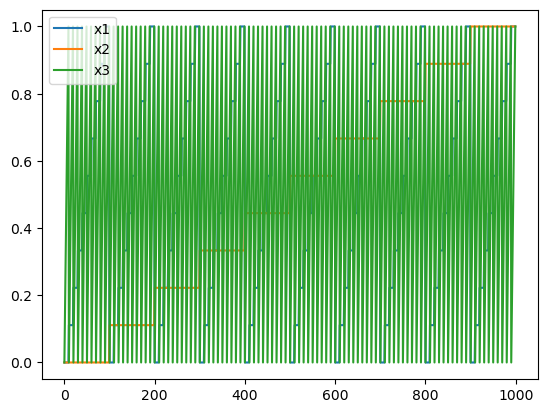

In [7]:
# visualize scan
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

run_data.plot(y=X.vocs.variable_names)

## run scan

In [8]:
for index, row in run_data.iterrows():
    print(index)
    X.evaluate_data(row)

cannot connect to x
cannot connect to x
cannot connect to x


UnboundLocalError: local variable 'result' referenced before assignment

In [ ]:
# examine the data stored in Xopt
X.data